# Australian Renewable Energy Generation


The aim of this project is to predict how much power a wind or solar farm will generate based on weather conditions.

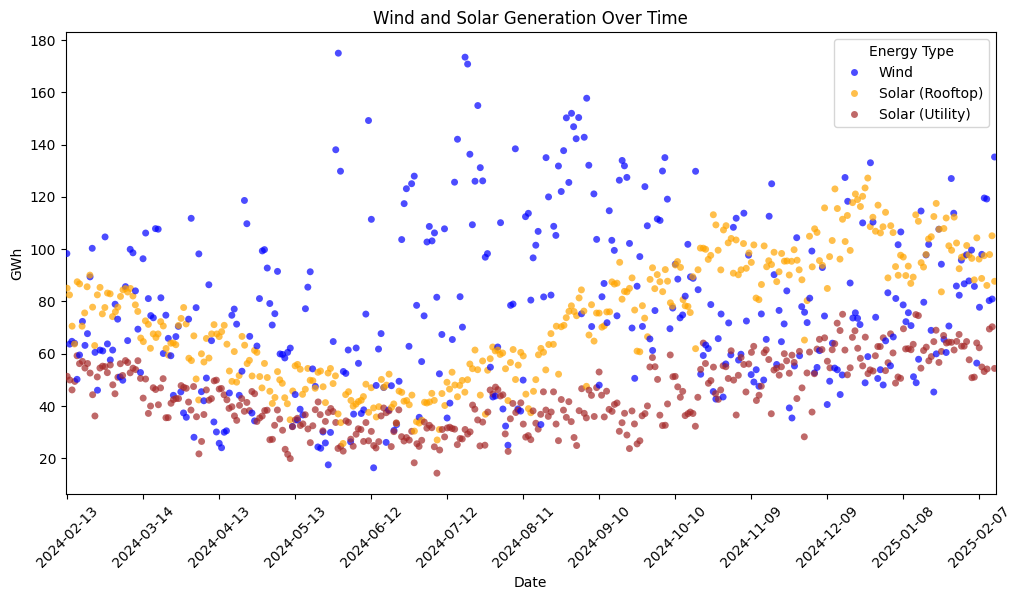

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

EnergyGeneration_df = pd.read_csv("2024EnergyGenerationAus.csv")
# print(EnergyGeneration_df.info())
# print(EnergyGeneration_df.describe())

# Visualizing the "Wind - GWh" and "Solar (Rooftop) - GWh" columns over time
# Ensure the date or time column is in datetime format & add DOY column
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['date'])
EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

# Reshape data to long format for Wind and Solar
EnergyGeneration_df_long = EnergyGeneration_df.melt(
    id_vars='Date', 
    value_vars=['Wind -  GWh', 'Solar (Rooftop) -  GWh', 'Solar (Utility) -  GWh'], 
    var_name='Energy Type', 
    value_name='GWh'
)

# Simplify energy type labels
EnergyGeneration_df_long['Energy Type'] = EnergyGeneration_df_long['Energy Type'].str.replace(' -  GWh', '')

# Plot using stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(
    x='Date', 
    y='GWh', 
    hue='Energy Type', 
    data=EnergyGeneration_df_long, 
    jitter=True, 
    alpha=0.7, 
    palette={'Wind': 'blue', 'Solar (Rooftop)': 'orange', 'Solar (Utility)': 'brown'}
)

# Adding plot labels and title
plt.title('Wind and Solar Generation Over Time')
plt.xlabel('Date')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend(title='Energy Type')
plt.xticks(ticks=plt.xticks()[0][::30], rotation=45)

# Show plot
plt.show()

Use NASA POWER API to get weather parameters for solar and wind generation in Queensland

In [ ]:
import pandas as pd
import numpy as np
import concurrent.futures
from api_fetch import fetch_weather_data

# Define Queensland's approximate lat/lon bounds for general parameters
latitudes = np.arange(-29, -10, 2)   # South QLD (-29) to North (-10) in 2-degree steps
longitudes = np.arange(138, 154, 2)  # West QLD (138) to East Coast (154) in 2-degree steps

# Define specific wind farm coordinates (latitude, longitude)
wind_farm_coords = [
    (-26.55, 151.33),  # Coopers Gap Wind Farm
    (-26.80, 150.27),  # Dulacca Wind Farm
    (-17.2, 145.4),    # Mount Emerald Wind Farm
    (-17.5922, 145.5306),  # Windy Hill Wind Farm
    (-17.06, 146.75),  # Kaban Green Power Hub
    (-21, 145)         # Kennedy Energy Park
]

# Parameters for weather data
parameters = "T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX"       # Temperature, Solar Radiation, Wind Speed at 50m and its maximum
start_date = "20240213"
end_date = "20250213"

# Store results
all_data = []

# Function to fetch weather data for a given set of parameters and location
def fetch_loc_weatherData(lat, lon, parameters, isWindFarm=False):
    print(f"Fetching data for Lat: {lat}, Lon: {lon} with parameters: {parameters}...")
    data = fetch_weather_data(
        parameters=parameters,
        latitude=lat,
        longitude=lon,
        start_date=start_date,
        end_date=end_date
    )
    if data is not None:
        data["Latitude"] = lat
        data["Longitude"] = lon
        data["isWindFarm"] = isWindFarm  # Add the isWind column
        # Convert YEAR + DOY to datetime format
        data["Date"] = pd.to_datetime(data["YEAR"].astype(str) + data["DOY"].astype(str), format="%Y%j")
    return data

# Execute API calls concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    
    # Grid locations for non-wind parameters
    for lat in latitudes:
        for lon in longitudes:
            futures.append(executor.submit(
                fetch_loc_weatherData, lat, lon, parameters, isWindFarm=False
            ))
    
    # Wind farm locations for wind parameters
    for lat, lon in wind_farm_coords:
        futures.append(executor.submit(
            fetch_loc_weatherData, lat, lon, parameters, isWindFarm=True
        ))
    
    # Collect results
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data.append(result)

# Combine all results into a single DataFrame
if all_data:
    WeatherData_df = pd.concat(all_data, ignore_index=True)
    print(WeatherData_df.head())
else:
    print("No data retrieved.")

# Data Cleaning
# Remove rows with invalid values
invalid_value = -999
WeatherData_df = WeatherData_df.replace(invalid_value, np.nan).dropna()

# Drop rows in EnergyGeneration_df if no corresponding date in WeatherData_df
EnergyGeneration_df = EnergyGeneration_df[EnergyGeneration_df['Date'].isin(WeatherData_df['Date'])]


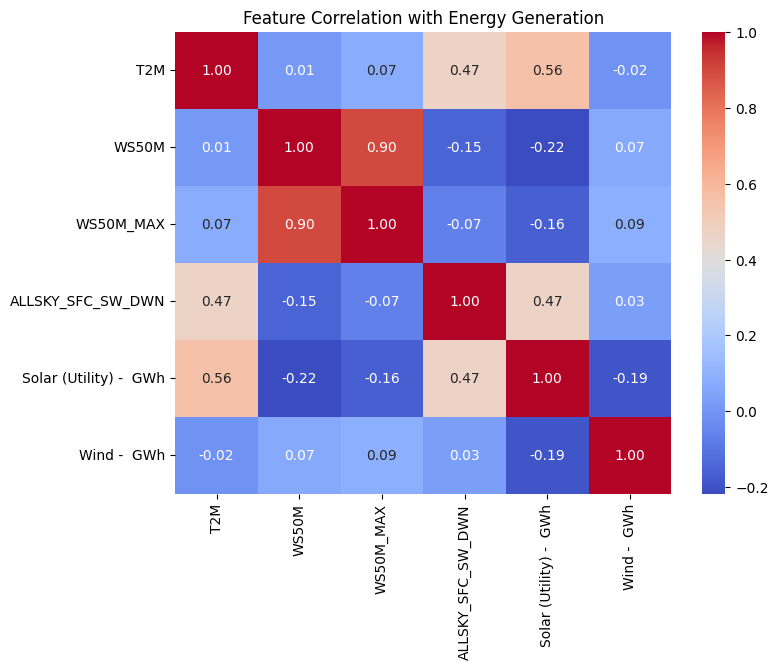

In [3]:
### Data Exploration: Check correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt


# Merge WeatherData_df and EnergyGeneration_df on Date
merged_df = pd.merge(WeatherData_df, EnergyGeneration_df, on="Date", how="inner")

# Select only relevant columns
correlation_matrix = merged_df[["T2M", "WS50M", "WS50M_MAX", "ALLSKY_SFC_SW_DWN", "Solar (Utility) -  GWh", "Wind -  GWh"]].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Energy Generation")
plt.show()


## Model Building
#### 1. Linear Regression

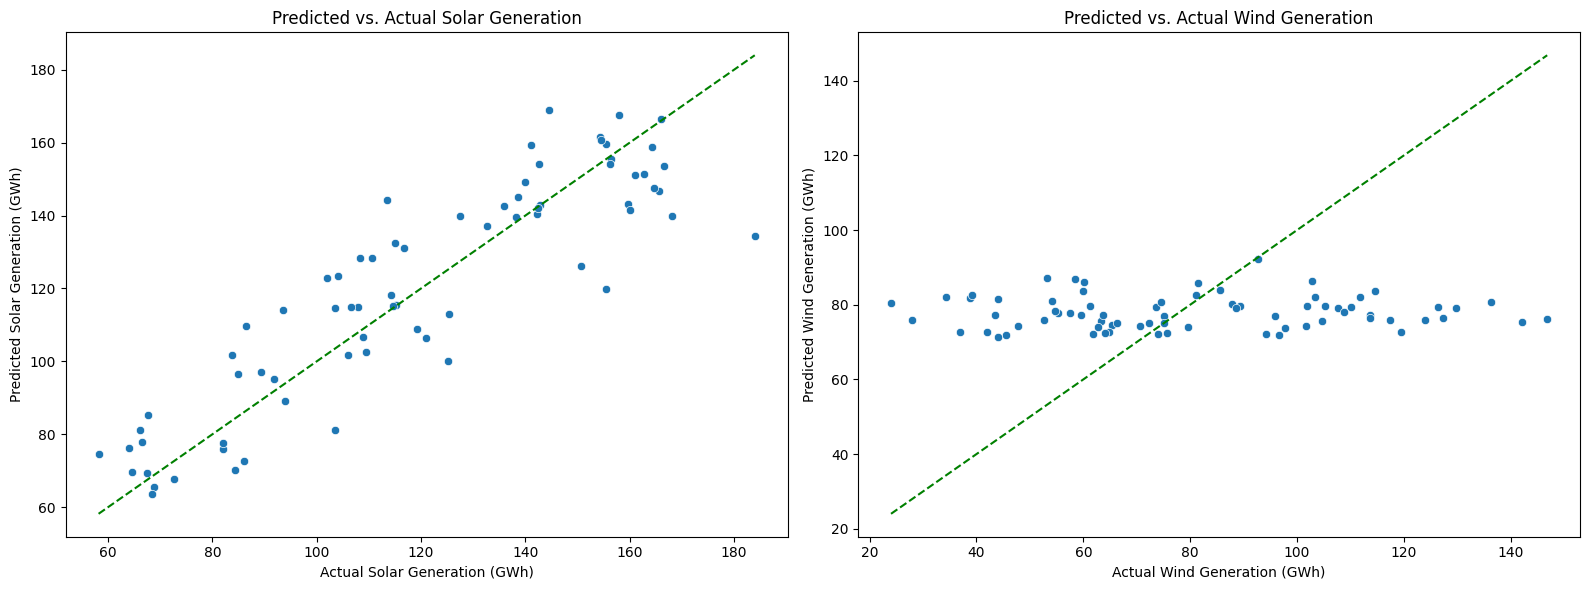

Solar MAE: 11.861687433231863
Wind MAE: 24.684407023015428


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS50M_MAX', 'WS50M']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_df = EnergyGeneration_df.sort_values(by='DOY')
X = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN']]
y = EnergyGeneration_df['Solar (Utility) -  GWh'] + EnergyGeneration_df['Solar (Rooftop) -  GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_solar = model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS50M','WS50M_MAX']].mean().reset_index() # Group by DOY and take the average for wind speed
X = WeatherData_avg_wind[['WS50M','WS50M_MAX']]  ** 3 # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_df['Wind -  GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_wind = model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))